In [2]:
import pandas as pd
import numpy as np
from csv import reader
from numpy import linalg as la
from sys import exit
from haversine import haversine
import math
from operator import itemgetter

#시각화 도구
import folium
from folium.features import DivIcon
import random
import matplotlib.pyplot as plt

# 전역 변수 설정
FILE_SAVE_DIR = './Data_set_0826/' #있다면 추가 해주기 (상대경로)
line_color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
                    'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] 
# Global Variable Setting

# Nicname = '5CAC8432AE4EC54B'
# Huzzi = '44754E5A077F32B4'
# oizi = '2DDB3706DE4F7B45'
kyounghwan = '3963650B38CAF112'
hyeryeong = '4CCF4C0B0F953026'
pyeongju = '8A57AE95DD4629A7'
joongho = '9E7F4CB4F4A6A6D4'
yujin = 'F9888CC2D3053565'

PATIENT_UID = kyounghwan # 감염자 UID
TARGET_UID =  hyeryeong # 조사 대상자 UID

# Map Setting
Raw_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
Filter_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
mass_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
compare_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사

#Call CSV file
def load_GPS_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_gps"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['loggingTime']).dt.strftime('%Y-%m-%d %H:%M:%s')
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","latitude","longitude","provider"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass
'''
def load_Sateillate_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_sate"+".csv", sep=",", dtype='unicode')
        
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME']).dt.strftime('%Y-%m-%d %H:%M:%s')
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","SNR AVERAGE","SATELLITE COUNT"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass

def merge_gps_sati_set(UID): # for weight_filter
    gps_df = load_GPS_set(UID)
    sat_df = load_Sateillate_set(UID)
    merge_df = pd.merge(gps_df,sat_df, how='left', on = ['TIME STAMP','UID'])
    return merge_df
'''


################### RAW DATA FUNC ######################
def extract_raw_data(UID,start,end):
    Dataframe = load_GPS_set(UID)
    marker_list = []
    for count in range(start,end):
        marker_point_lati = float(Dataframe.loc[count,'latitude'])
        marker_point_long = float(Dataframe.loc[count,'longitude'])
        marker_point_time = Dataframe.loc[count,'TIME STAMP']
        marker_point = [marker_point_time, marker_point_lati, marker_point_long]
        marker_list.append(marker_point)
    is_idx = Dataframe.index <= end
    Dataframe = Dataframe[is_idx]
    return marker_list, Dataframe
    
################### ABOUT MAP DROWING FUNC #####################
def draw_Polyline_map(map, marker_list, draw_color):
    replace_list = []
    for marker_point in marker_list:
        replace_list.append(marker_point[1:3])
    folium.PolyLine(locations=replace_list,tooltip='Polyline',color=draw_color).add_to(map)

def draw_index_map(map, marker_list):
    count = len(marker_list)
    for marker_point in marker_list:
        folium.Marker(marker_point[1:3], icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
        html='<div style="font-size: 10pt; color : black">'+str(count)+'</div>',
        )).add_to(map)
        count = count - 1

def draw_circle_map(map, marker_list,draw_radius,draw_color):
    for marker_point in marker_list:
        folium.CircleMarker(location=marker_point[1:3], radius=draw_radius, color= draw_color).add_to(map)
        
def draw_arrow_map(map, start_list, end_list, line_color, dot_color):
    for start_point in start_list:
        for end_point in end_list:
            if(start_point[0]==end_point[0]):
                try:
                    rot_x = end_point[1] - start_point[1]
                    rot_y = end_point[2] - start_point[2]
                    rot = math.acos(haversine([start_point[1],0],[end_point[1],0])/haversine(start_point[1:3],end_point[1:3]))
                    # folium.CircleMarker(location=end_point[1:3], radius=1, color= dot_color).add_to(map)
                    folium.PolyLine(locations=[start_point[1:3],end_point[1:3]],tooltip='Polyline',color=line_color).add_to(map)
                    folium.CircleMarker(location=start_point[1:3], radius=3, color= dot_color).add_to(map)
                    folium.RegularPolygonMarker(end_point[1:3], fill_color='blue', number_of_sides=3, radius=3, rotation=rot).add_to(map)
                except IndexError :
                    break
                except ZeroDivisionError:
                    break


In [3]:
FILTER_CONSTANT = 5

soo_raw, soo_df = extract_raw_data(soo,1,517)
soo_avg_point = []

for idx in range(len(soo_raw)):
    x = soo_raw[idx][1]
    y = soo_raw[idx][2]
    avg_x = 0
    avg_y = 0
    for avgIdx in range(idx,idx + FILTER_CONSTANT):
        try:
            avg_x += soo_raw[avgIdx][1]
            avg_y += soo_raw[avgIdx][2]
        except IndexError:
            break
    avg_x = avg_x / FILTER_CONSTANT
    avg_y = avg_y / FILTER_CONSTANT
    point = [soo_raw[idx][0], avg_x, avg_y]
    soo_avg_point.append(point)
    
ryeong_raw, ryeong_df = extract_raw_data(ryeong,1,314)
ryeong_avg_point = []

for idx in range(len(ryeong_raw)):
    x = ryeong_raw[idx][1]
    y = ryeong_raw[idx][2]
    avg_x = 0
    avg_y = 0
    for avgIdx in range(idx,idx + FILTER_CONSTANT):
        try:
            avg_x += ryeong_raw[avgIdx][1]
            avg_y += ryeong_raw[avgIdx][2]
        except IndexError:
            break
    avg_x = avg_x / FILTER_CONSTANT
    avg_y = avg_y / FILTER_CONSTANT
    point = [ryeong_raw[idx][0], avg_x, avg_y]
    ryeong_avg_point.append(point)
    
kyoung_raw, kyoung_df = extract_raw_data(kyounghwan,1,516)
kyoung_avg_point = []

for idx in range(len(kyoung_raw)):
    x = kyoung_raw[idx][1]
    y = kyoung_raw[idx][2]
    avg_x = 0
    avg_y = 0
    for avgIdx in range(idx,idx + FILTER_CONSTANT):
        try:
            avg_x += kyoung_raw[avgIdx][1]
            avg_y += kyoung_raw[avgIdx][2]
        except IndexError:
            break
    avg_x = avg_x / FILTER_CONSTANT
    avg_y = avg_y / FILTER_CONSTANT
    point = [kyoung_raw[idx][0], avg_x, avg_y]
    kyoung_avg_point.append(point)

# draw_arrow_map(Filter_map,soo_raw,soo_avg_point,"red", "blue")
# draw_arrow_map(Filter_map,ryeong_raw,ryeong_avg_point,"red", "blue")
draw_arrow_map(Filter_map,kyoung_raw,kyoung_avg_point,"red", "blue")

Filter_map

In [4]:
soo_speed_vec = []
ryeong_speed_vec = []
kyoung_speed_vec = []

for idx in range(len(soo_raw)):
    try:
        speed_x = soo_raw[idx][1] - soo_avg_point[idx][1]
        speed_y = soo_raw[idx][2] - soo_avg_point[idx][2]
        speed = [soo_raw[idx][0], speed_x, speed_y]
        soo_speed_vec.append(speed)
    except IndexError:
        break

for idx in range(len(ryeong_raw)):
    try:
        speed_x = ryeong_raw[idx][1] - ryeong_avg_point[idx][1]
        speed_y = ryeong_raw[idx][2] - ryeong_avg_point[idx][2]
        speed = [ryeong_raw[idx][0], speed_x, speed_y]
        ryeong_speed_vec.append(speed)
    except IndexError:
        break
    
for idx in range(len(kyoung_raw)):
    try:
        speed_x = kyoung_raw[idx][1] - kyoung_avg_point[idx][1]
        speed_y = kyoung_raw[idx][2] - kyoung_avg_point[idx][2]
        speed = [kyoung_raw[idx][0], speed_x, speed_y]
        kyoung_speed_vec.append(speed)
    except IndexError:
        break

In [5]:
#contact 비교
from numpy import dot
from numpy.linalg import norm
def extractTime(DataFrame):
    timeStamp = np.unique(DataFrame["TIME STAMP"])
    # convertTimeStamp = timeStamp[~pd.isnull(timeStamp)]
    # resTimeStamp = np.unique(convertTimeStamp)
    return timeStamp

patient = kyoung_df
tester = soo_df

tester = tester[["TIME STAMP", "latitude", "longitude"]]
tester["TIME STAMP"] = pd.to_datetime(tester["TIME STAMP"]).dt.strftime('%Y-%m-%d %H:%M')

patient = patient[["TIME STAMP", "latitude", "longitude"]]
patient["TIME STAMP"] = pd.to_datetime(patient["TIME STAMP"]).dt.strftime('%Y-%m-%d %H:%M')

time_stamp = extractTime(patient)

contact_df = pd.DataFrame(columns=["TIME", "Distance", "Cosine", "Threshold", "Contact"])
contact_df["TIME"] = time_stamp
contact_df.set_index("TIME", inplace = True)
for time in time_stamp:
    is_patient_time = patient["TIME STAMP"] == time
    is_tester_time = tester["TIME STAMP"] == time
    is_time_patient_df = patient[is_patient_time]
    is_time_tester_df = tester[is_tester_time]
    is_time_patient_df = is_time_patient_df.reset_index(drop=True)
    is_time_tester_df = is_time_tester_df.reset_index(drop=True)

    distance_list = []
    for idx_patient in range(0, len(is_time_patient_df.index)):
        for idx_tester in range(0, len(is_time_tester_df.index)):
            try:
                patient_point = [float(is_time_patient_df.loc[idx_patient,"latitude"]),float(is_time_patient_df.loc[idx_patient,"longitude"])]
                tester_point = [float(is_time_tester_df.loc[idx_tester,"latitude"]),float(is_time_tester_df.loc[idx_tester,"longitude"])]
                distance = haversine(patient_point,tester_point, unit = 'm')
                distance_list.append(distance)
            except IndexError:
                break
            except KeyError:
                break
    contact_df.loc[time,"Distance"] = min(distance_list)
    if min(distance_list) <= 5:
        cosine_similar_list = []
        for speed_point_patient in kyoung_speed_vec:
            if time in speed_point_patient[0]:
                for speed_point_tester in ryeong_speed_vec:
                    if time in speed_point_tester[0] :
                        print(time, speed_point_patient[1:3], speed_point_tester[1:3])
                        cosine_similar = dot(speed_point_patient[1:3], speed_point_tester[1:3]) / (norm(speed_point_patient[1:3]) * norm(speed_point_tester[1:3]))
                        cosine_similar_list.append(cosine_similar)
        contact_df.loc[time,"Cosine"] = np.mean(cosine_similar_list)
    else : 
        contact_df.loc[time,"Cosine"] = 0

2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [0.0, 0.0]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-1.2011999999117506e-05, -5.452600001376595e-05]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-1.2682000004815563e-05, -0.00012409599999330112]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-1.0420000002397956e-05, -0.00021818200001177956]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-7.426000003363242e-06, -0.00034655199999633624]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [4.043999999936432e-05, -0.00019980799999075316]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-1.2639999980024186e-06, -0.0001984320000048001]
2022-04-02 18:14 [-1.888000006999846e-06, 3.3442000002992245e-05] [-1.2259999998320836e-05, -0.00013465199998563548]
2022-04-02 18:14 [-3.1126000003212084e-05, 9.052800000119987e-05] [0.0, 0.0]
2022-04-02 18:14 [-3.11260000032

C:\Users\User\AppData\Local\Temp/ipykernel_9868/2132630292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester["TIME STAMP"] = pd.to_datetime(tester["TIME STAMP"]).dt.strftime('%Y-%m-%d %H:%M')
C:\Users\User\AppData\Local\Temp/ipykernel_9868/2132630292.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient["TIME STAMP"] = pd.to_datetime(patient["TIME STAMP"]).dt.strftime('%Y-%m-%d %H:%M')
c:\Users\User\anaconda3\envs\wifi\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean o

 [-9.9569999996163e-05, 0.0002058379999994031] [2.6865999998904044e-05, 6.140399999310375e-05]
2022-04-02 18:43 [-9.9569999996163e-05, 0.0002058379999994031] [1.9126000005087462e-05, 8.600399999636466e-05]
2022-04-02 18:43 [-9.9569999996163e-05, 0.0002058379999994031] [4.599200000399151e-05, 0.00014740800000367926]
2022-04-02 18:43 [-9.9569999996163e-05, 0.0002058379999994031] [7.285799999579012e-05, 0.00020881200001099387]
2022-04-02 18:43 [-9.9569999996163e-05, 0.0002058379999994031] [-0.0001589119999962918, -4.648000000884167e-06]
2022-04-02 18:43 [-9.9569999996163e-05, 0.0002058379999994031] [-0.00011018800000783813, 0.0002115279999941322]
2022-04-02 18:43 [-0.0001535239999981286, 0.00017022000000110893] [2.6865999998904044e-05, 6.140399999310375e-05]
2022-04-02 18:43 [-0.0001535239999981286, 0.00017022000000110893] [1.9126000005087462e-05, 8.600399999636466e-05]
2022-04-02 18:43 [-0.0001535239999981286, 0.00017022000000110893] [4.599200000399151e-05, 0.00014740800000367926]
2022-0

In [6]:
WINDOW_SIZE = 10
EXPOSED_CONSTANT = 5
THRESHOLD = 0.1
exposed_df = pd.DataFrame(columns=["TIME", "Cosine_avg", "Exposed", "Threshold","GroundTruth"])
exposed_df["TIME"] = time_stamp
exposed_df["Threshold"] = THRESHOLD
KH_SR_GroundTruth = ["FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","TRUE","TRUE","TRUE","TRUE","TRUE","TRUE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","FALSE","TRUE","TRUE","TRUE","TRUE","TRUE","TRUE","TRUE","TRUE"]
exposed_df["GroundTruth"] = KH_SR_GroundTruth

cosine_avg_list = []
contact_df = contact_df.reset_index(drop=True)
for idx in range(0, len(contact_df.index)):
    cosine_avg = 0
    for window_idx in range(idx, idx+WINDOW_SIZE):
        try:
            cosine = contact_df.loc[window_idx, "Cosine"]
            cosine_avg += cosine
        except KeyError:
            cosine_avg = 0
            continue
    cosine_avg = cosine_avg / WINDOW_SIZE
    cosine_avg_list.append(cosine_avg)
exposed_df["Cosine_avg"] = cosine_avg_list
for idx in range(len(exposed_df["Cosine_avg"])):
    if exposed_df.loc[idx, "Cosine_avg"] >= THRESHOLD:
        exposed_df.loc[idx, "Exposed"] = "TRUE"
    else :
        exposed_df.loc[idx, "Exposed"] = "FALSE"
# exposed_df.to_csv('KH_SR.csv')
cnt = 0
for idx in range(len(exposed_df.index)):
    if exposed_df.loc[idx, "Exposed"] == exposed_df.loc[idx, "GroundTruth"]:
        cnt +=1
acc = cnt / len(exposed_df.index)
print(cnt, len(exposed_df.index), acc)

26 44 0.5909090909090909


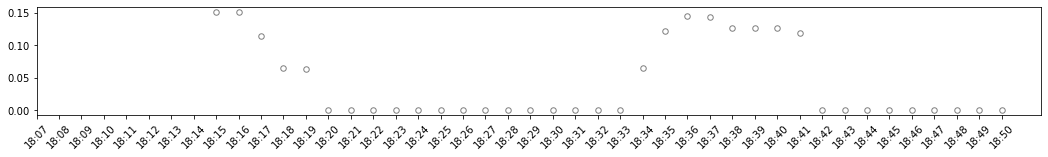

In [7]:
import matplotlib.pyplot as plt
exposed_df["TIME"] = pd.to_datetime(exposed_df["TIME"]).dt.strftime('%H:%M')
plt.figure(figsize=(18,2))
# plt.scatter(exposed_df["TIME"], KH_SR_GroundTruth, s=30, c='b', edgecolors='black', alpha=0.5)
plt.scatter(exposed_df["TIME"], cosine_avg_list, s=30, c='w', edgecolors='black', alpha=0.5)
plt.xticks(exposed_df["TIME"], rotation = 45)
plt.show()
# draw_arrow_map(compare_map,kyoung_raw,kyoung_avg_point,"red", "blue")

# compare_map

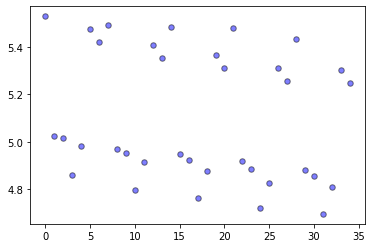

In [8]:
# plt.scatter(np.arange(len(cosine_similar_list)),cosine_similar_list, s=30, c='b', edgecolors='black', alpha=0.5)
plt.scatter(np.arange(len(distance_list)),distance_list, s=30, c='b', edgecolors='black', alpha=0.5)